# Reddit Sentiment Analysis

In [ ]:
# !pip install gensim
# !pip install keras
# !pip install pandas

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

### Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the post (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the post ( 2087)
* **date**: the date of the post (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that posted (robotickilldozr)
* **text**: the text of the post (Lyx is cool)

In [ ]:
dataset_filename = os.listdir("../input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/training.1600000.processed.noemoticon.csv


In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 1.09 s, sys: 13 ms, total: 1.1 s
Wall time: 1.11 s


Text(0.5,1,'Dataset labels distribuition')

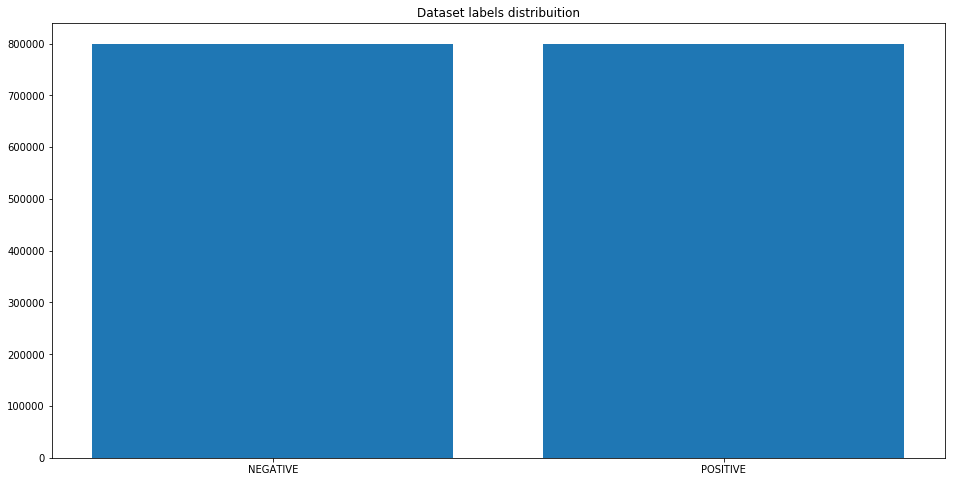

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 6s, sys: 170 ms, total: 1min 6s
Wall time: 1min 6s


### Split train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 3.2 s, sys: 534 ms, total: 3.73 s
Wall time: 3.74 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2023-06-29 08:18:39,994 : INFO : collecting all words and their counts
2023-06-29 08:18:39,996 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-06-29 08:18:40,022 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2023-06-29 08:18:40,046 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2023-06-29 08:18:40,072 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2023-06-29 08:18:40,099 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2023-06-29 08:18:40,124 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2023-06-29 08:18:40,151 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2023-06-29 08:18:40,179 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2023-06-29 08:18:40,207 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-06-29 08:18:45,089 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2023-06-29 08:18:46,108 : INFO : EPOCH 1 - PROGRESS: at 3.80% examples, 310263 words/s, in_qsize 15, out_qsize 0
2023-06-29 08:18:47,156 : INFO : EPOCH 1 - PROGRESS: at 8.58% examples, 342823 words/s, in_qsize 13, out_qsize 3
2023-06-29 08:18:48,176 : INFO : EPOCH 1 - PROGRESS: at 13.15% examples, 350806 words/s, in_qsize 16, out_qsize 0
2023-06-29 08:18:49,185 : INFO : EPOCH 1 - PROGRESS: at 18.00% examples, 362138 words/s, in_qsize 15, out_qsize 0
2023-06-29 08:18:50,198 : INFO : EPOCH 1 - PROGRESS: at 22.87% examples, 368852 words/s, in_qsize 12, out_qsize 2
2023-06-29 08:18:51,213 : INFO : EPOCH 1 - PROGRESS: at 27.21% examples, 365873 words/s, in_qsize 15, out_qsize 0
2023-06-29 08:18:52,228 : INFO : EPOCH 1 - PROGRESS: at 32.08% examples, 370082 words/s, in_qsize 16, out_qsize 0
2023-06-29 08:18:53,236 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 22min 27s, sys: 6.63 s, total: 22min 34s
Wall time: 12min 6s


(263121003, 295270528)

In [ ]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2023-06-29 08:30:51,373 : INFO : precomputing L2-norms of word weight vectors
/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5782203674316406),
 ('loves', 0.5563244223594666),
 ('loved', 0.542149007320404),
 ('adore', 0.5200611352920532),
 ('amazing', 0.5077873468399048),
 ('looove', 0.4962958097457886),
 ('loveee', 0.46787068247795105),
 ('awesome', 0.4630008935928345),
 ('loooove', 0.4456910192966461),
 ('lovee', 0.44040095806121826)]

### Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 27.7 s, sys: 162 ms, total: 27.9 s
Wall time: 27.9 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 44.7 s, sys: 1.06 s, total: 45.7 s
Wall time: 45.8 s


### Label Encoder

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 560s 486us/step - loss: 0.5043 - acc: 0.7501 - val_loss: 0.4655 - val_acc: 0.7787
Epoch 2/8
1152000/1152000 [==============================] - 569s 494us/step - loss: 0.4829 - acc: 0.7655 - val_loss: 0.4586 - val_acc: 0.7831
Epoch 3/8
1152000/1152000 [==============================] - 569s 494us/step - loss: 0.4757 - acc: 0.7699 - val_loss: 0.4573 - val_acc: 0.7852
Epoch 4/8
1152000/1152000 [==============================] - 569s 494us/step - loss: 0.4717 - acc: 0.7722 - val_loss: 0.4564 - val_acc: 0.7861
Epoch 5/8
1152000/1152000 [==============================] - 569s 494us/step - loss: 0.4695 - acc: 0.7736 - val_loss: 0.4532 - val_acc: 0.7870
Epoch 6/8
1152000/1152000 [==============================] - 571s 496us/step - loss: 0.4674 - acc: 0.7748 - val_loss: 0.4521 - val_acc: 0.7885
Epoch 7/8
1152000/1152000 [==============================] - 568s 493us/step - loss: 0.46

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 55s 172us/step

ACCURACY: 0.789584375
LOSS: 0.44853601384162906
CPU times: user 1min 17s, sys: 6.11 s, total: 1min 23s
Wall time: 55.1 s


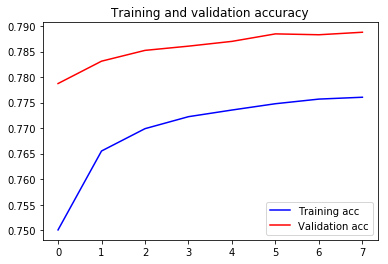

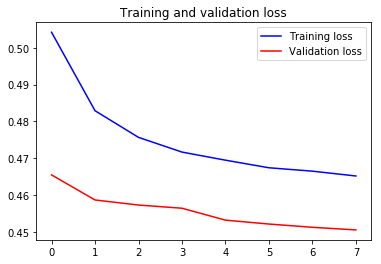

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("Bank of America nurses $100bn paper loss after big bet in bond market")

{'label': 'NEGATIVE',
 'score': 0.20024628937244415,
 'elapsed_time': 0.17540574073791504}

In [ ]:
predict("Micron Delivers Strong Forecast in Sign That Chip Glut Is Easing")

{'label': 'NEUTRAL',
 'score': 0.6587681174278259,
 'elapsed_time': 0.1715834140777588}

In [ ]:
predict("$ETRN Equitrans has amazing value right now")

{'label': 'POSITIVE',
 'score': 0.9618452191352844,
 'elapsed_time': 0.1482686996459961}

In [ ]:
predict("Nissan reportedly spied on former COO As CEO searched for leverage")

{'label': 'NEUTRAL',
 'score': 0.5806874632835388,
 'elapsed_time': 0.1599874496459961}

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 21s 65us/step
CPU times: user 13 s, sys: 1.28 s, total: 14.3 s
Wall time: 21.6 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

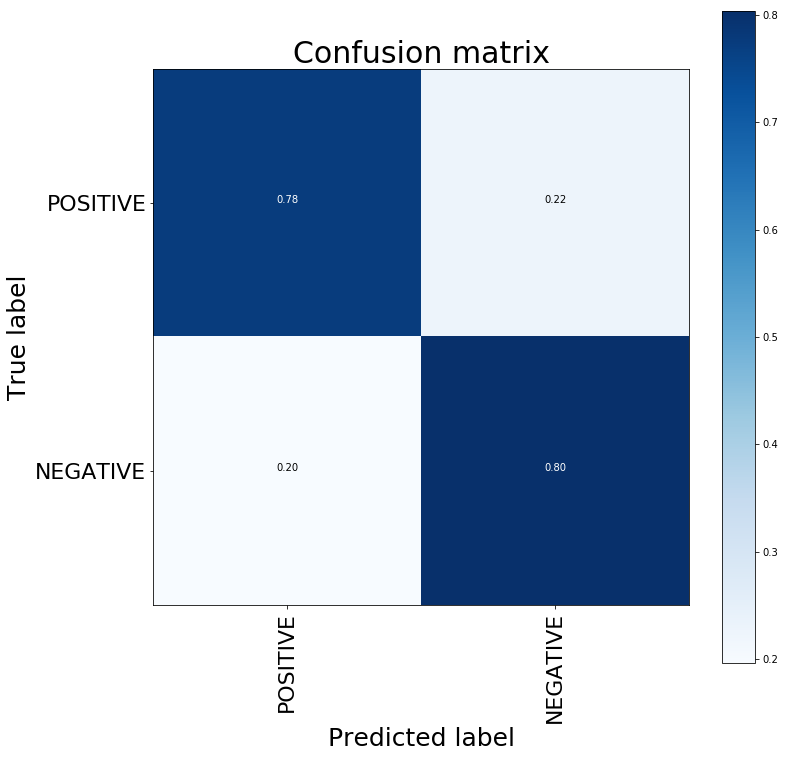

CPU times: user 1.82 s, sys: 191 ms, total: 2.01 s
Wall time: 1.68 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.78      0.80      0.79    160506

   micro avg       0.79      0.79      0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.789584375

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2023-06-29 10:13:44,828 : INFO : saving Word2Vec object under model.w2v, separately None
2023-06-29 10:13:44,833 : INFO : not storing attribute vectors_norm
2023-06-29 10:13:44,838 : INFO : not storing attribute cum_table
2023-06-29 10:13:45,848 : INFO : saved model.w2v
